In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:98% !important;}</style>'))

In [3]:
### Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
### Seaborn style
sns.set_style("whitegrid")
import jaydebeapi
import os
from lightgbm import LGBMClassifier

In [4]:
train = pd.read_csv("train_v3.csv.gz", compression='gzip')
train.shape

(10039826, 31)

In [5]:
train.head()

,liste_type,duree,distance_autoroute,distance_train,lag1_distance_autoroute,lag1_distance_train,lag1_duree,lead1_distance_autoroute,lead1_distance_train,lead1_duree,...,max_distance_train_by_hour,max_distance_autoroute_by_hour,uniq_cell_by_demiheure,distance_parcourue_by_demiheure,max_distance_train_by_demiheure,max_distance_autoroute_by_demiheure,uniq_cell_by_quartheure,distance_parcourue_by_quartheure,max_distance_train_by_quartheure,max_distance_autoroute_by_quartheure
0,Autoroute,0,0.000303,0.04247,NaN,NaN,0.0,0.003684,0.036710,0.0,...,0.053887,0.036826,7,0.000000,0.053887,0.001688,8,0.085153,0.053887,0.003684
1,Autres,0,0.008218,0.00775,0.008218,0.00775,0.0,0.010047,0.012332,0.0,...,0.022145,0.022804,4,0.042008,0.022145,0.022804,3,0.010844,0.012332,0.010047
2,Autres,0,0.008218,0.00775,0.008218,0.00775,0.0,0.010047,0.012332,0.0,...,0.022145,0.022804,3,0.010844,0.012332,0.010047,3,0.010844,0.012332,0.010047
3,Autres,0,0.008218,0.00775,0.008218,0.00775,0.0,0.010047,0.012332,1.0,...,0.022145,0.022804,4,0.042008,0.022145,0.022804,3,0.010844,0.012332,0.010047
4,Autres,0,0.008218,0.00775,0.008218,0.00775,719.0,0.010047,0.012332,0.0,...,0.012332,0.010047,3,0.016266,0.012332,0.010047,2,0.005422,0.012332,0.010047


In [6]:
test = pd.read_csv("test_v3.csv.gz", compression='gzip')
test.shape

(2550463, 31)

In [7]:
test.head(5)

,uid,duree,distance_autoroute,distance_train,lag1_distance_autoroute,lag1_distance_train,lag1_duree,lead1_distance_autoroute,lead1_distance_train,lead1_duree,...,max_distance_train_by_hour,max_distance_autoroute_by_hour,uniq_cell_by_demiheure,distance_parcourue_by_demiheure,max_distance_train_by_demiheure,max_distance_autoroute_by_demiheure,uniq_cell_by_quartheure,distance_parcourue_by_quartheure,max_distance_train_by_quartheure,max_distance_autoroute_by_quartheure
0,"2144065,506353",0,NaN,NaN,NaN,NaN,0.0,0.008455,0.012321,83.0,...,0.047985,0.031710,41,0.475162,0.047985,0.031710,35,0.324523,0.037791,0.031710
1,2143883,0,NaN,NaN,NaN,NaN,0.0,0.008455,0.012321,0.0,...,0.070774,0.055665,78,1.624420,0.050731,0.055665,52,0.876776,0.039443,0.055665
2,"1435909,1497057,1496125",0,NaN,NaN,NaN,NaN,0.0,0.008455,0.012321,0.0,...,0.070774,0.055665,10,0.143427,0.025094,0.014579,25,0.879221,0.061336,0.055665
3,"2144243,506080",0,NaN,NaN,0.008455,0.012321,0.0,0.008455,0.012321,0.0,...,0.070774,0.055665,78,1.624420,0.050731,0.055665,52,0.876776,0.039443,0.055665
4,"3066703,3066822,3019759,3019767",7,NaN,NaN,0.008455,0.012321,26.0,0.008455,0.012321,15.0,...,0.060178,0.055665,81,1.184498,0.060178,0.055665,52,0.450552,0.026315,0.025081


In [8]:
train['liste_type']=train['liste_type'].replace(['Autoroute','Train','Autres','Train,Autoroute', 'Autoroute,Train'],[0,1,2,1,0])

In [9]:
y2 = train['liste_type']

In [10]:
train['liste_type'].unique()

array([0, 2, 1], dtype=int64)

# ajouts de quelques features

In [11]:
train["autoroute"] = np.where(train["distance_autoroute"] <train["distance_train"] ,1,0)
test["autoroute"]  = np.where(test["distance_autoroute"] <test["distance_train"] ,1,0)

train["vitesse1"] =train["distance_cell_celllag1b"] / train["delta_lag1_date_session"]
train["vitesse2"] =train["distance_cell_celllag1b"] / train["delta_lead1_date_session"]
train["vitesse3"] =train["distance_cell_celllead1b"] / train["delta_lag1_date_session"]
train["vitesse4"] =train["distance_cell_celllead1b"] / train["delta_lead1_date_session"]

test["vitesse1"] =test["distance_cell_celllag1b"] / test["delta_lag1_date_session"]
test["vitesse2"] =test["distance_cell_celllag1b"] / test["delta_lead1_date_session"]
test["vitesse3"] =test["distance_cell_celllead1b"] / test["delta_lag1_date_session"]
test["vitesse4"] =test["distance_cell_celllead1b"] / test["delta_lead1_date_session"]



In [17]:
features_cat=['dayofweek']

In [18]:
from sklearn.preprocessing import LabelEncoder
for v in features_cat: 
    train[v].fillna('#NA#', inplace=True)
    test[v].fillna('#NA#', inplace=True)
    le = LabelEncoder()
    train[v] = le.fit_transform(train[v])
    test[v] = le.fit_transform(test[v])

In [19]:
features = [x for x in train.columns if x not in ['liste_type','cell','region','departement','latitude_2', 'longitude_2']]

In [20]:
print(features)

['duree', 'distance_autoroute', 'distance_train', 'lag1_distance_autoroute', 'lag1_distance_train', 'lag1_duree', 'lead1_distance_autoroute', 'lead1_distance_train', 'lead1_duree', 'delta_lag1_distance_autoroute', 'delta_lag1_distance_train', 'delta_lag1_date_session', 'delta_lead1_distance_autoroute', 'delta_lead1_distance_train', 'delta_lead1_date_session', 'distance_cell_celllag1b', 'distance_cell_celllead1b', 'dayofweek', 'uniq_cell_by_hour', 'distance_parcourue_by_hour', 'max_distance_train_by_hour', 'max_distance_autoroute_by_hour', 'uniq_cell_by_demiheure', 'distance_parcourue_by_demiheure', 'max_distance_train_by_demiheure', 'max_distance_autoroute_by_demiheure', 'uniq_cell_by_quartheure', 'distance_parcourue_by_quartheure', 'max_distance_train_by_quartheure', 'max_distance_autoroute_by_quartheure', 'autoroute', 'vitesse1', 'vitesse2', 'vitesse3', 'vitesse4']


In [21]:
nr_fold=5
random_state=1234
folds = StratifiedKFold(n_splits=nr_fold, 
                            shuffle=True, 
                            random_state=random_state)

In [22]:
params2 = {
            'objective': 'multiclass', 
            'num_class': 3, 
            'learning_rate' : 0.1,
            'boosting_type': 'gbdt', 
            'n_jobs': -1, 
            'max_depth': 7, 
              'n_estimators': 100, 
             'num_boost_round':10000,
            'metric': 'multi_logloss'}

In [23]:
from sklearn.metrics import accuracy_score
# utilise pour stocker les resultats
oof_preds2  = np.zeros((len(train), np.unique(y2).shape[0]))
oof_preds2  = np.zeros((len(train)))

test_preds2 = []
importances2 = pd.DataFrame()
clfs = []
for fold_, (trn_, val_) in enumerate(folds.split(train, y2)):

        ## model poour les 54 classes
        trn_x, trn_y = train[features].iloc[trn_], y2.iloc[trn_]
        val_x, val_y = train[features].iloc[val_], y2.iloc[val_]
    
        clf = LGBMClassifier(**params2)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            categorical_feature=features_cat ,
            verbose=100,
            eval_metric='multi_logloss',
            early_stopping_rounds=50
        )

        oof_preds2[val_] = clf.predict(val_x, num_iteration=clf.best_iteration_)
        test_preds2.append(clf.predict(test[features], num_iteration=clf.best_iteration_) )  
        imp_df = pd.DataFrame()
        imp_df['feature'] = features
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances2 = pd.concat([importances2, imp_df], axis=0, sort=False)
        clfs.append(clf)

        #print('MODEL 2 ....: no {}-fold loss: {}'.format(fold_ + 1, accuracy_score(val_y, oof_preds2[val_, :]) ) )  
    

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['dayofweek']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.0558294	valid_1's multi_logloss: 0.0561477
[200]	training's multi_logloss: 0.0390536	valid_1's multi_logloss: 0.039499
[300]	training's multi_logloss: 0.0310155	valid_1's multi_logloss: 0.0316165
[400]	training's multi_logloss: 0.0253673	valid_1's multi_logloss: 0.0260136
[500]	training's multi_logloss: 0.0216054	valid_1's multi_logloss: 0.0223283
[600]	training's multi_logloss: 0.0187144	valid_1's multi_logloss: 0.019581
[700]	training's multi_logloss: 0.0161662	valid_1's multi_logloss: 0.01709
[800]	training's multi_logloss: 0.0140695	valid_1's multi_logloss: 0.0151003
[900]	training's multi_logloss: 0.0123152	valid_1's multi_logloss: 0.0133994
[1000]	training's multi_logloss: 0.0108801	valid_1's multi_logloss: 0.0120437
[1100]	training's multi_logloss: 0.00964578	valid_1's multi_logloss: 0.0108511
[1200]	training's multi_logloss: 0.00869778	valid_1's multi_logloss: 0.009949
[1300]	trainin

In [24]:
def print_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(13, 11))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:100])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

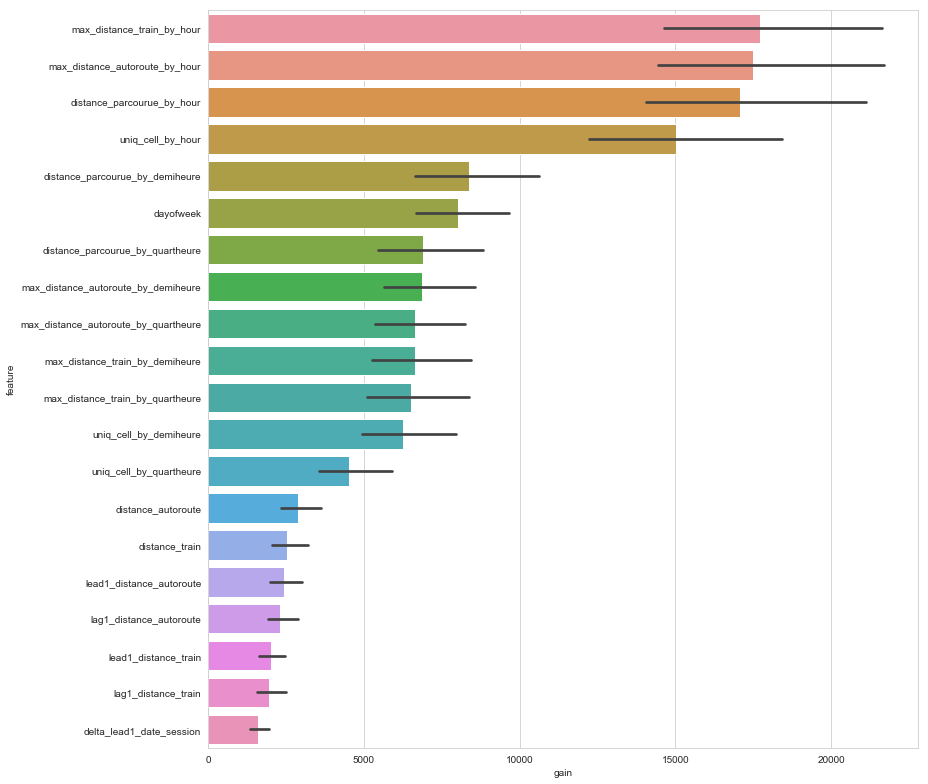

In [25]:
print_importances(importances2)

# validation

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
oof_preds2

array([0., 2., 2., ..., 2., 2., 2.])

In [28]:
accuracy_score(y2, oof_preds2)

0.9985220859405333

In [29]:
validation_df = pd.DataFrame()
validation_df['target'] = y2
validation_df['preds'] = oof_preds2


# submission

# vote

In [30]:
vote_df = pd.DataFrame()
vote_df['cv0'] = test_preds2[0] 
vote_df['cv1'] = test_preds2[1] 
vote_df['cv2'] = test_preds2[2] 
vote_df['cv3'] = test_preds2[3] 
vote_df['cv4'] = test_preds2[4] 

In [31]:
mask0 = pd.concat([vote_df[column] == 0 for column in vote_df], axis=1, keys=vote_df.columns)
result0 =vote_df[mask0].isnull().sum(axis=1)

mask1 = pd.concat([vote_df[column] == 1 for column in vote_df], axis=1, keys=vote_df.columns)
result1 =vote_df[mask1].isnull().sum(axis=1)

mask2= pd.concat([vote_df[column] == 2 for column in vote_df], axis=1, keys=vote_df.columns)
result2 =vote_df[mask2].isnull().sum(axis=1)



In [32]:
vote_df['sum0'] = result0
vote_df['sum1'] =result1
vote_df['sum2'] =result2


In [33]:
vote_df.shape

(2550463, 8)

In [34]:
vote_df['final_vote'] =0
vote_df['final_vote'] = np.where((vote_df['sum0'] <vote_df['sum1']) & (vote_df['sum0'] <vote_df['sum2']), 0,vote_df['final_vote'] )
vote_df['final_vote'] = np.where((vote_df['sum1'] <vote_df['sum0']) & (vote_df['sum1'] <vote_df['sum2']), 1,vote_df['final_vote'] )
vote_df['final_vote'] = np.where((vote_df['sum2'] <vote_df['sum0']) & (vote_df['sum2'] <vote_df['sum1']), 2,vote_df['final_vote'] )


In [35]:
vote_df.head(10)

,cv0,cv1,cv2,cv3,cv4,sum0,sum1,sum2,final_vote
0,0,0,0,0,0,0,5,5,0
1,0,0,0,0,0,0,5,5,0
2,0,0,0,0,0,0,5,5,0
3,0,0,0,0,0,0,5,5,0
4,0,0,0,0,0,0,5,5,0
5,0,0,0,0,0,0,5,5,0
6,0,0,0,0,0,0,5,5,0
7,0,0,0,0,0,0,5,5,0
8,0,0,0,0,0,0,5,5,0
9,0,0,0,0,0,0,5,5,0


In [36]:
preds_ = test_preds2[0] 
preds_ = vote_df['final_vote'].values

In [37]:
preds_

array([0, 0, 0, ..., 2, 1, 2], dtype=int64)

In [38]:
submission = pd.DataFrame()
submission['uid'] = test['uid']
submission['type'] = np.round(preds_)

In [39]:
submission.head()

,uid,type
0,"2144065,506353",0
1,2143883,0
2,"1435909,1497057,1496125",0
3,"2144243,506080",0
4,"3066703,3066822,3019759,3019767",0


In [40]:
#submission.to_csv("submission_small_transport_v2.csv",index=False)

In [41]:
#submission = pd.read_csv("submission_small_transport_v2_smooth.csv") 

In [42]:
submission.shape

(2550463, 2)

In [43]:
uid_liste = pd.read_csv("uid_ref.csv.gz",compression="gzip")


In [44]:
uid_liste.shape

(6610545, 2)

In [45]:
uid_liste.head()

,uid_liste,uids
0,"2144065,506353",2144065
1,"2144065,506353",506353
2,2143883,2143883
3,"1435909,1497057,1496125",1435909
4,"1435909,1497057,1496125",1497057


In [46]:
submission = submission.merge(uid_liste, left_on='uid', right_on="uid_liste", how='inner')

In [47]:
del submission['uid']
del submission['uid_liste']
submission['uid']=submission['uids']
del submission['uids']

In [48]:
submission.head()

,type,uid
0,0,2144065
1,0,506353
2,0,2143883
3,0,1435909
4,0,1497057


In [49]:
UC_momentdevie_sub_full0 = pd.read_csv("UC_momentdevie_sub_full0.csv")
del UC_momentdevie_sub_full0['type']

In [50]:
submission.to_csv("submission_full_transport_v2.csv",index=False)

In [51]:

submission = submission.merge(UC_momentdevie_sub_full0, on='uid', how='inner')

In [52]:
submission.shape

(453041, 2)

In [53]:
submission.head()

,type,uid
0,0,3019475
1,2,3341715
2,2,1891595
3,2,3344115
4,2,3342315


In [54]:
if 0 :
    submission.to_csv("submission_transport_v2_smooth.csv",index=False)

In [56]:
if 1:
    #submission.to_csv("submission_transport"²++"_v3_vote.csv",index=False)
    submission.to_csv("submission_transport_v4_vote.csv",index=False)

## ACC test:  96.902046